In [1]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Free parameters to fit (later on)

In [2]:
#COST = 0.5
#B=6
#A=60 
#u_skill = .625 #mean of beta
#tao_skill = 20 #variance of beta

### Functions

In [3]:
def prob_reward(e,diff,skill, A, B):
    """Return the probability of getting the reward
    
    Parameters
    ----------
    e : numeric or array-like
        Description of parameter 'effort'
    diff: numeric or array-like 
        Description of parameter 'difficulty"
    skill: numeric or array-like 
        Description of parameter 'skill"
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    
    Returns
    -------
    Numeric or array-like value of probabilty of getting a reward between 0-1
    ...
    """
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) 


def get_effort_multidim(cost, diff, skill, A, B, reward=1):
    """Function that returns optimal effort given different skills and difficulties.
    Runs utility function of the form utility = reward* probability of getting
    reward - cost* effort 
    Cost is set but scales with effort
    Reward is set but scales with probability of getting it
    This function finds the argmax value of utility and returns that as the 
    'optimal' effort that should be exerted given some difficuly, skill, cost, and reward.
    

    Parameters
    ----------
    cost : numeric description of 'cost'
    diff: numeric or array-like 
        Description of parameter 'difficulty'
    skill: numeric or array-like 
        Description of parameter 'skill'
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    reward: numeric set to 1 for 'reward'

    Returns
    -------
    Ndarray of effort with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]



def create_priors_opt(n_samples, tao_skill, u_skill, cost, A, B, diff, reward=1, 
                      effort_threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    diff: numeric or array-like parameter
        of difficulty
    reward : numeric value of reward
    effort_threshold: threshold that determines boundry
        Between high and low effort
    
    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diff, A=A, B=B,
    )

    high_effort = efforts > effort_threshold
    success = prob_reward(efforts, diff, skills, A, B) > np.random.random(n_samples)

    return skills,  success, high_effort, efforts

def run_model_highdiff(cost, A, B, u_skill, tao_skill, high_diff, n_samples=10000):
    """function that takes in free parameters and cost and returns model predictions (predicted skill)
    when difficulty is high only and reward is achieved. Essentially P(skill| effort, difficulty = high). 
    It runs the create_priors_opt function. Set high difficulty as .8
    
    Parameters
    ----------
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    u_skill: numeric, mean of skill beta function
    tao_skill: numeric, variance of skill beta function
    n_samples : int of number of samples
        You want to run
    
    Returns
    -------
    Ndarray of skill when difficulty is high and success is true, effort when dififculty is high and success is true
    """
    
    np.random.seed(0)
    REWARD=1
    
    high_diff_skills, high_diff_success, high_diff_high_effort, effort_high_diff = create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, diff = high_diff
    )
    

    skill_high_diff = high_diff_skills[high_diff_success ] # get range of skills when diff is high and success is true
    eff_high_diff = effort_high_diff[high_diff_success ] # get range of effort when diff is high and success is true

    return skill_high_diff , eff_high_diff


## Plot Utility Functions

#### Variables I set --> free parameters

In [4]:
REWARD = 1
COST = .5
skilled = .8
unskilled = .4
hard = .7
easy = .3
A = 40
B = 9

#### First let's plot prob(reward) for varying levels of skill, effort, and difficulty

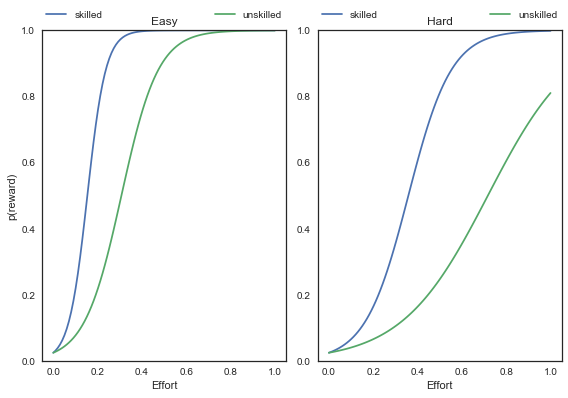

In [5]:
es=np.linspace(0,1,100)
p0 = [prob_reward(e,easy,unskilled, A, B) for e in es]
p1 = [prob_reward(e,easy,skilled,A, B) for e in es]

plt.subplot(1,2,1)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0, label = "unskilled")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('Easy')

p0 = [prob_reward(e,hard,unskilled,A, B) for e in es]
p1 = [prob_reward(e,hard,skilled,A, B) for e in es]
plt.subplot(1,2,2)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0,label = "unskilled")
plt.tight_layout()
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ;  plt.title('Hard')

#### Function that is similar to "get_effort_multidem" but simpiler for plotting purposes
* runs a utility function that finds the peak utility of "effort" for each combination of difficulty and skill

In [6]:
def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

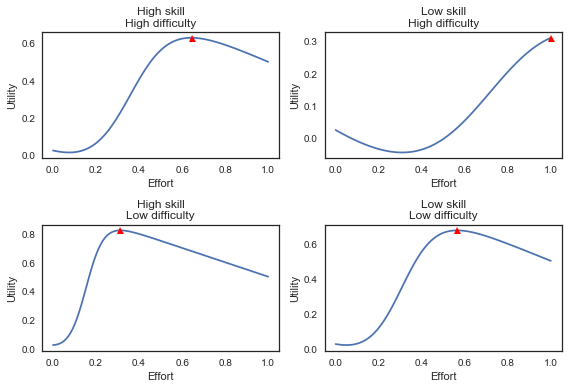

In [7]:
plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

#### These plots capture our intutions about what should happen in each situation
* High skill, high difficulty: you should have to try pretty hard
* Low skill, high difficulty: you should have to try REALLY hard
* High skill, low difficulty: you shouldn't have to try very hard
* Low skill, low difficulty: you should have to try pretty hard

All things being equal, the rank of trying here from most to least is:
    1. low skill + high diff
    2. high skill + high diff
    3. low skill + low diff
    4. high skill + low diff

## Run model to find P(Skill | Effort, Difficulty = high)

In [8]:
 skill_high_diff, effort_high_diff= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, high_diff =.8, n_samples=10000) #play with parameters


In [9]:
d = {'Skill':  skill_high_diff, 'Effort': effort_high_diff, "Difficulty":.8}
diff8_df = pd.DataFrame(data=d)
#diff_df.head()

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


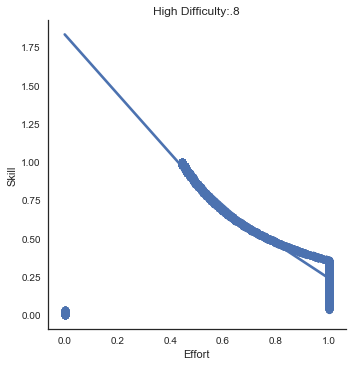

In [10]:
ax = sns.lmplot(x="Effort", y="Skill",scatter=True, ci=None, data=diff8_df, lowess=True)
plt.title('High Difficulty:.8')
plt.show()

## Interpretation
When it's hard, you have to put in some effort (above .5). When you are VERY not skilled, you don't try and some random times you succeed. The highest skilled person puts in 50% effort. 

* we don't love the no effort and success points  - change function? relu function

## Trying out high diff between .6 and .9

In [11]:
skill_high_diff_6, effort_high_diff_6= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, high_diff =.6, n_samples=10000) #play with parameters
d_6 = {'Skill':  skill_high_diff_6, 'Effort': effort_high_diff_6, "Difficulty":.6}
diff6_df = pd.DataFrame(data=d_6)

skill_high_diff_7, effort_high_diff_7= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, high_diff =.7, n_samples=10000) #play with parameters
d_7 = {'Skill':  skill_high_diff_7, 'Effort': effort_high_diff_7, "Difficulty":.7}
diff7_df = pd.DataFrame(data=d_7)

skill_high_diff_9, effort_high_diff_9= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, high_diff =.9, n_samples=10000) #play with parameters
d_9 = {'Skill':  skill_high_diff_9, 'Effort': effort_high_diff_9, 'Difficulty':.9}
diff9_df = pd.DataFrame(data=d_9)

frames = [diff6_df, diff7_df, diff8_df,diff9_df]
all_data = pd.concat(frames)

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


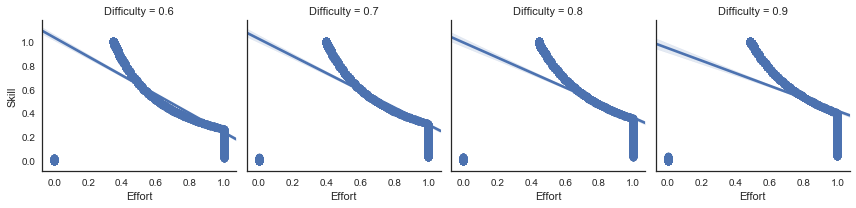

In [12]:
g = sns.FacetGrid(all_data, col="Difficulty",  margin_titles=True)
g.map(sns.regplot, "Effort", "Skill", fit_reg=True);


## Let's try a few different prob_reward functions

1. (effort x skill) / difficulty (what we have above) -- this equals (skill/difficulty)*effort
2. effort x skill - difficulty

In [13]:
def prob_reward2(e,diff,skill, A, B):
    """Return the probability of getting the reward -->effort * skill - difficulty
    
    Parameters
    ----------
    e : numeric or array-like
        Description of parameter 'effort'
    diff: numeric or array-like 
        Description of parameter 'difficulty"
    skill: numeric or array-like 
        Description of parameter 'skill"
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    
    Returns
    -------
    Numeric or array-like value of probabilty of getting a reward between 0-1
    ...
    """
    return 1/(1 + A * np.exp(-((e * skill)-diff)  * B)) 


## Reason this function is bad: if skill is less than diff, you never try! Doesn't follow our intuition

### Plot functions for prob reward #2 = Effort*Skill - Difficulty

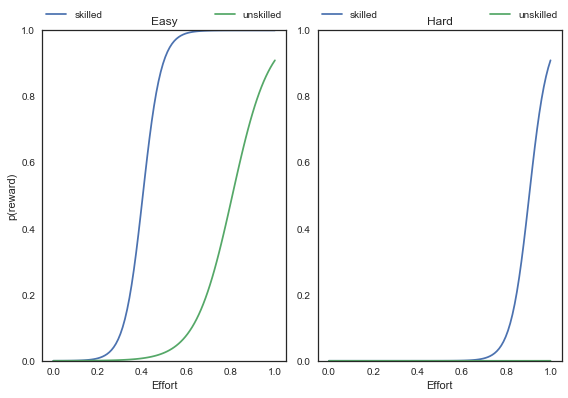

In [14]:
REWARD = 1
COST = .001
skilled = .8
unskilled = .4
hard = .7
easy = .3
A = 2
B = 30

es=np.linspace(0,1,100)
p0 = [prob_reward2(e,easy,unskilled, A, B) for e in es]
p1 = [prob_reward2(e,easy,skilled,A, B) for e in es]

plt.subplot(1,2,1)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0, label = "unskilled")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('Easy')

p0 = [prob_reward2(e,hard,unskilled,A, B) for e in es]
p1 = [prob_reward2(e,hard,skilled,A, B) for e in es]
plt.subplot(1,2,2)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0,label = "unskilled")
plt.tight_layout()
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ;  plt.title('Hard')

### Plot utility functions for Prob reward #2

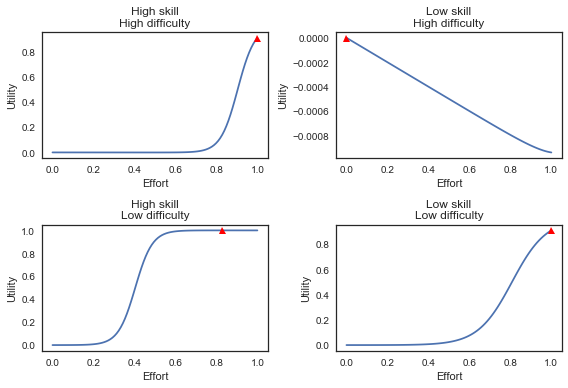

In [15]:
A = 2
B = 30

def get_effort2(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward2(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

plt.subplot(2,2,1)
effort,Us,es=get_effort2(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort2(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort2(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort2(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

In [16]:
def get_effort_multidim_it(cost, diff, skill, A, B,prob_reward, reward=1):
    """Function that returns optimal effort given different skills and difficulties.
    Runs utility function of the form utility = reward* probability of getting
    reward - cost* effort 
    Cost is set but scales with effort
    Reward is set but scales with probability of getting it
    This function finds the argmax value of utility and returns that as the 
    'optimal' effort that should be exerted given some difficuly, skill, cost, and reward.
    

    Parameters
    ----------
    cost : numeric description of 'cost'
    diff: numeric or array-like 
        Description of parameter 'difficulty'
    skill: numeric or array-like 
        Description of parameter 'skill'
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    reward: numeric set to 1 for 'reward'

    Returns
    -------
    Ndarray of effort with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]



def create_priors_opt_it(n_samples, tao_skill, u_skill, cost, A, B, diff, prob_reward, reward=1, 
                      effort_threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    diff: numeric or array-like parameter
        of difficulty
    reward : numeric value of reward
    effort_threshold: threshold that determines boundry
        Between high and low effort
    
    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    efforts = get_effort_multidim_it(
        cost=cost, skill=skills, diff=diff, A=A, B=B,prob_reward  = prob_reward
    )

    high_effort = efforts > effort_threshold
    success = prob_reward(efforts, diff, skills, A, B) > np.random.random(n_samples)

    return skills,  success, high_effort, efforts

def run_model_highdiff(cost, A, B, u_skill, tao_skill, prob_reward, high_diff, n_samples=10000):
    """function that takes in free parameters and cost and returns model predictions (predicted skill)
    when difficulty is high only and reward is achieved. Essentially P(skill| effort, difficulty = high). 
    It runs the create_priors_opt function. Set high difficulty as .8
    
    Parameters
    ----------
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    u_skill: numeric, mean of skill beta function
    tao_skill: numeric, variance of skill beta function
    n_samples : int of number of samples
        You want to run
    
    Returns
    -------
    Ndarray of skill when difficulty is high and success is true, effort when dififculty is high and success is true
    """
    
    np.random.seed(0)
    REWARD=1
    
    high_diff_skills, high_diff_success, high_diff_high_effort, effort_high_diff = create_priors_opt_it(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B, 
        diff = high_diff, prob_reward = prob_reward
    )
    
    skill_high_diff = high_diff_skills[high_diff_success ] # get range of skills when diff is high and success is true
    eff_high_diff = effort_high_diff[high_diff_success ] # get range of effort when diff is high and success is true

    return skill_high_diff , eff_high_diff

In [17]:
 skill_high_diff, effort_high_diff= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1,prob_reward = prob_reward2, high_diff = .6,  n_samples=10000) 

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/julialeonard/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/Users/julialeonard/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/julialeonard/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


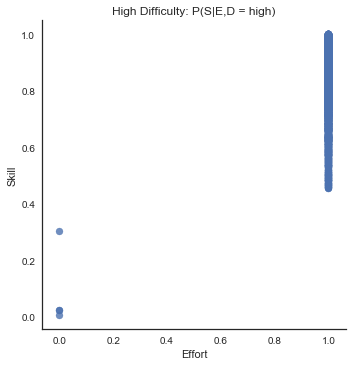

In [18]:
d = {'Skill':  skill_high_diff, 'Effort': effort_high_diff}
diff_df = pd.DataFrame(data=d)
ax = sns.lmplot(x="Effort", y="Skill",scatter=True, ci=None, data=diff_df, lowess=True)
plt.title('High Difficulty: P(S|E,D = high)')
plt.show()

## Try out Relu p(reward) with no A and B

In [19]:
def prob_reward_relu(e,diff,skill,A,B):
     pR = e * skill / diff
     pR[pR<0] = 0
     pR[pR>1] = 1
     return pR   

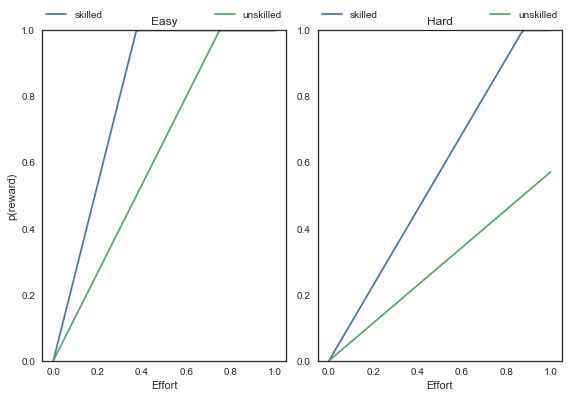

In [20]:
def prob_reward_relu_plot(e,diff,skill,A,B):
    return min(1, max(0,e * skill / diff))

es=np.linspace(0,1,100)
p0 = [prob_reward_relu_plot(e,easy,unskilled, A, B) for e in es]
p1 = [prob_reward_relu_plot(e,easy,skilled,A, B) for e in es]

plt.subplot(1,2,1)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0, label = "unskilled")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('Easy')

p0 = [prob_reward_relu_plot(e,hard,unskilled,A, B) for e in es]
p1 = [prob_reward_relu_plot(e,hard,skilled,A, B) for e in es]
plt.subplot(1,2,2)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0,label = "unskilled")
plt.tight_layout()
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ;  plt.title('Hard')

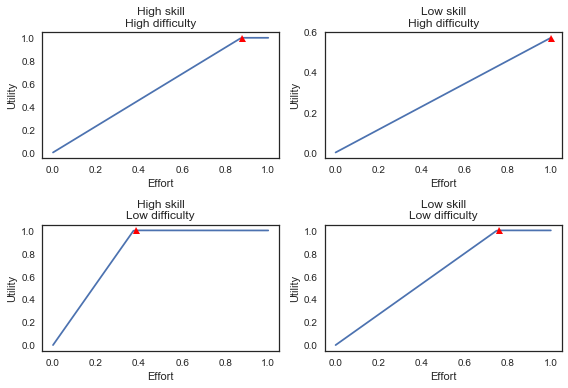

In [21]:
def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward_relu_plot(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

In [22]:
 skill_high_diff, effort_high_diff= run_model_highdiff(cost = .5, A = 2, B = 10, u_skill = .5, tao_skill = 1,prob_reward = prob_reward_relu, high_diff=.8,  n_samples=10000) 

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


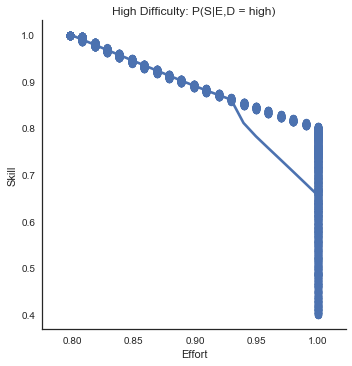

In [23]:
d = {'Skill':  skill_high_diff, 'Effort': effort_high_diff, "Difficulty":.8}
diff8_df = pd.DataFrame(data=d)
ax = sns.lmplot(x="Effort", y="Skill",scatter=True, ci=None, data=diff8_df, lowess=True)
plt.title('High Difficulty: P(S|E,D = high)')
plt.show()

## This looks good! Relu function results are nice because they eliminate those random people who don't try and succeed!

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


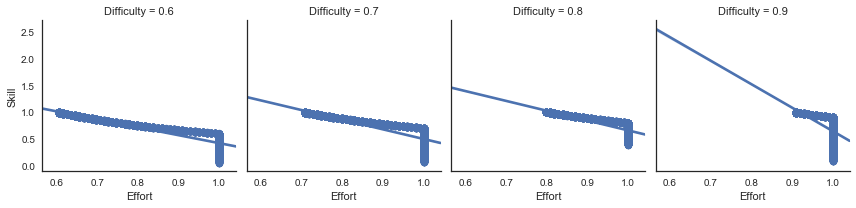

In [24]:
skill_high_diff_6, effort_high_diff_6= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1,prob_reward = prob_reward_relu, high_diff =.6, n_samples=10000) #play with parameters
d_6 = {'Skill':  skill_high_diff_6, 'Effort': effort_high_diff_6, "Difficulty":.6}
diff6_df = pd.DataFrame(data=d_6)

skill_high_diff_7, effort_high_diff_7= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, prob_reward = prob_reward_relu,high_diff =.7, n_samples=10000) #play with parameters
d_7 = {'Skill':  skill_high_diff_7, 'Effort': effort_high_diff_7, "Difficulty":.7}
diff7_df = pd.DataFrame(data=d_7)

skill_high_diff_9, effort_high_diff_9= run_model_highdiff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, prob_reward = prob_reward_relu,high_diff =.9, n_samples=10000) #play with parameters
d_9 = {'Skill':  skill_high_diff_9, 'Effort': effort_high_diff_9, 'Difficulty':.9}
diff9_df = pd.DataFrame(data=d_9)

frames = [diff6_df, diff7_df, diff8_df,diff9_df]
all_data = pd.concat(frames)

g = sns.FacetGrid(all_data, col="Difficulty",  margin_titles=True)
g.map(sns.regplot, "Effort", "Skill", fit_reg=True);

## To match up with the MTURK data, run P(Skill | Difficulty, Effort = low, medium, high)
* using relu function

In [25]:

def create_priors_opt_eff_it(n_samples, tao_skill, u_skill,u_diff, tao_diff, cost, A, B, effort, prob_reward, reward=1):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    diff: numeric or array-like parameter
        of difficulty
    reward : numeric value of reward
    effort_threshold: threshold that determines boundry
        Between high and low effort
    
    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    diffs = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)

    success = prob_reward(effort, diffs, skills, A, B) > np.random.random(n_samples)
    

    return skills,  success, diffs,effort

def run_model_eff(cost, A, B, u_skill, tao_skill,u_diff, tao_diff,  prob_reward, effort, n_samples=10000):
    """function that takes in free parameters and cost and returns model predictions (predicted skill)
    when difficulty is high only and reward is achieved. Essentially P(skill| effort, difficulty = high). 
    It runs the create_priors_opt function. Set high difficulty as .8
    
    Parameters
    ----------
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    u_skill: numeric, mean of skill beta function
    tao_skill: numeric, variance of skill beta function
    n_samples : int of number of samples
        You want to run
    
    Returns
    -------
    Ndarray of skill when difficulty is high and success is true, effort when dififculty is high and success is true
    """
    
    np.random.seed(0)
    REWARD=1
    
    eff_skills, eff_success, eff_difficulty,eff_eff = create_priors_opt_eff_it(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill,u_diff = u_diff, tao_diff=tao_diff, cost=cost, A=A, B=B, 
        effort = effort, prob_reward = prob_reward
    )
    
    final_skills = eff_skills[eff_success ] # get range of skills when effort is set and success is true
    final_diffs = eff_difficulty[eff_success] # get range of effort when diff is high and success is true

    return final_skills , final_diffs

In [26]:
skill_eff3, diff_eff3= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward_relu, effort =.3, n_samples=10000) #play with parameters
E3= {'Skill':  skill_eff3, 'Difficulty': diff_eff3, "Effort":.3}
eff3_df = pd.DataFrame(data=E3)

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


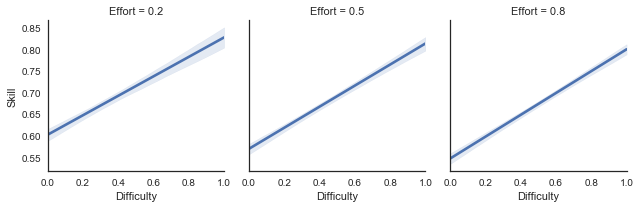

In [36]:
skill_eff2, diff_eff2= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward_relu, effort =.2, n_samples=10000) #play with parameters
E2= {'Skill':  skill_eff2, 'Difficulty': diff_eff2, "Effort":.2}
eff2_df = pd.DataFrame(data=E2)

skill_eff5, diff_eff5= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward_relu, effort =.5, n_samples=10000) #play with parameters
E5= {'Skill':  skill_eff5, 'Difficulty': diff_eff5, "Effort":.5}
eff5_df = pd.DataFrame(data=E5)

skill_eff8, diff_eff8= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward_relu, effort =.8, n_samples=10000) #play with parameters
E8= {'Skill':  skill_eff8, 'Difficulty': diff_eff8, "Effort":.8}
eff8_df = pd.DataFrame(data=E8)

frames = [eff2_df ,eff5_df,eff8_df]
all_data = pd.concat(frames)

g = sns.FacetGrid(all_data, col="Effort",  margin_titles=True)
g.map(sns.regplot, "Difficulty", "Skill", scatter=False, fit_reg=True);

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


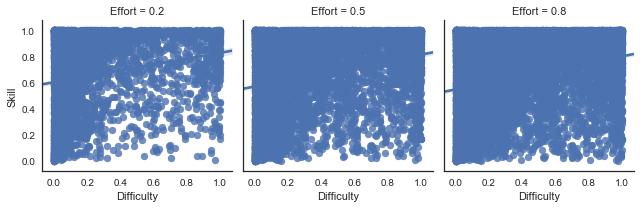

In [37]:
g = sns.FacetGrid(all_data, col="Effort",  margin_titles=True)
g.map(sns.regplot, "Difficulty", "Skill",  fit_reg=True);

## Try without Relu?


/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


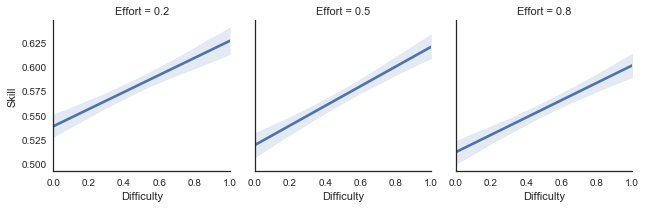

In [34]:
skill_eff2, diff_eff2= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward, effort =.2, n_samples=10000) #play with parameters
E2= {'Skill':  skill_eff2, 'Difficulty': diff_eff2, "Effort":.2}
eff2_df = pd.DataFrame(data=E2)

skill_eff5, diff_eff5= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward, effort =.5, n_samples=10000) #play with parameters
E5= {'Skill':  skill_eff5, 'Difficulty': diff_eff5, "Effort":.5}
eff5_df = pd.DataFrame(data=E5)

skill_eff8, diff_eff8= run_model_eff(cost = .1, A = 2, B = 10, u_skill = .5, tao_skill = 1, u_diff = 0.5, tao_diff=1,prob_reward = prob_reward, effort =.8, n_samples=10000) #play with parameters
E8= {'Skill':  skill_eff8, 'Difficulty': diff_eff8, "Effort":.8}
eff8_df = pd.DataFrame(data=E8)

frames = [eff2_df ,eff5_df,eff8_df]
all_data = pd.concat(frames)

g = sns.FacetGrid(all_data, col="Effort",  margin_titles=True)
g.map(sns.regplot, "Difficulty", "Skill", scatter=False, fit_reg=True);